In [1]:
# import sys
# import os
# import csv

# import xml.etree.ElementTree as Et
# from xml.etree.ElementTree import Element, ElementTree
# from PIL import Image

# import json

# from xml.etree.ElementTree import dump

In [127]:
## https://deepbaksuvision.github.io/Modu_ObjectDetection/posts/03_01_dataloader.html
from  matplotlib import pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch
import glob
import random
import os
import warnings
import numpy as np
from PIL import Image
from PIL import ImageFile
import os.path as osp
import sys
import torch
import torchvision
import torch.utils.data as data
import cv2

from Format import YOLO as cvtYOLO
from Format import VOC as cvtVOC
from smoke_augmentation import SmokeAugmentation

ImageFile.LOAD_TRUNCATED_IMAGES = True
SMOKE_ID = 1.0
DATA_ROOT = './data/fire/'

def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


class ImageFolder(Dataset):
    def __init__(self, folder_path, transform=None):
        self.files = sorted(glob.glob("%s/*.*" % folder_path))
        self.transform = transform

    def __getitem__(self, index):

        img_path = self.files[index % len(self.files)]
        img = np.array(
            Image.open(img_path).convert('RGB'),
            dtype=np.uint8)

        # Label Placeholder
        boxes = np.zeros((1, 5))

        # Apply transforms
        if self.transform:
            img, _ = self.transform((img, boxes))

        return img_path, img

    def __len__(self):
        return len(self.files)


class ListDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, resize=448, class_path='./fire.name.txt'):

        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.resize_factor = resize
        self.class_path = class_path


        with open(class_path) as f:
            self.classes = f.read().splitlines()

        self.image_dir = osp.join(DATA_ROOT, 'imgs/')
        self.annopath_dir = osp.join(DATA_ROOT, 'annotations/')
        self.image_ids = os.listdir(self.image_dir)
        self.annotation_ids = os.listdir(self.annopath_dir)
        self.batch_count = 0
        
        self.dict_flag , self.dict_data =  self.cvtDictData()
        
        if self.dict_flag is True :
            self.data = self.cvtDictData2Yolo(self.dict_data)
        
        self.yolo = cvtYOLO(os.path.abspath(self.class_path))
        self.smokeAugmentation = SmokeAugmentation(root = DATA_ROOT)
        self.smoke_dir = self.smokeAugmentation.smoke_dir
        self.smoke_ids = os.listdir(self.smoke_dir)
        
    def __getitem__(self, index):
        img_id = self.image_ids[index]
        img_path = osp.join(self.image_dir,img_id)
        
        #### 한글파일 깨짐현상 해결 위한 코드
        img_array = np.fromfile(img_path , np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        ##img = cv2.imread(img_path)
        ##img = Image.open(img_path).convert('RGB')
    
        ### label 가져오기     
        
        if self.dict_flag is not True :
            return -1;
        
        try:
            key = img_id[0:-4]
            target = self.data[key]
            semi = np.array([1])
            target , img , factor = self.smoke_aug_function(target , img , 0)
            
        except:
            semi = np.array([0])
            target = np.zeros([1,5])
            
        print(img_path)
        h , w , c = img.shape
        current_size = (h , w)
        img = cv2.resize(img , (self.resize_factor, self.resize_factor))
        img = torchvision.transforms.ToTensor()(img)
        # -----------
        #  Transform
        # -----------
        if self.transform is not None:
            img = self.transform(img)
          
        if self.target_transform is not None:
        # Future works
              pass
          
         
        return  img, target, semi, current_size 

    def __len__(self):
        return (len(self.image_ids))
    
    def cvtDictData(self):
        voc = cvtVOC()
        dict_flag, dict_data =voc.parse(os.path.join(self.annopath_dir))
        return dict_flag , dict_data 
    
    def cvtDictData2Yolo(self, dict_data):

        result = {}
      
        yolo = cvtYOLO(os.path.abspath(self.class_path))
      
        
        try:
            if self.dict_flag:
                flag, data =yolo.generate(dict_data)

            keys = list(data.keys())
#           keys = sorted(keys, key=lambda key: int(key.split("_")[-1]))

            for key in keys:
                contents = list(filter(None, data[key].split("\n")))
                target = []
                for i in range(len(contents)):
                    tmp = contents[i]
                    tmp = tmp.split(" ")
                    for j in range(len(tmp)):
                        tmp[j] = float(tmp[j])
                    target.append(tmp)
                result[key] = target

            return result

        except Exception as e:
            raise RuntimeError("Error : {}".format(e))
            
    def cvtData_By_Data (self, key):
        data_target = self.dict_data[key]
        new_target = {}
        new_target[key] = data_target
        flag, data =self.yolo.generate(new_target)
        if flag:
            contents = list(filter(None, data[key].split("\n")))
            result = []
            target = []
            for i in range(len(contents)):
                tmp = contents[i]
                tmp = tmp.split(" ")
                for j in range(len(tmp)):
                    tmp[j] = float(tmp[j])
                target.append(tmp)
            
        return target
    
    def search_smoke(self,target):
        for i in target:
            if i[0] == 1.0:
                return True
        return False
    
    def smoke_aug_function(self, target , dest_image , threshold):
        if self.search_smoke(target) is not True:
            x = random.randint(1,100)
            if x > threshold:
                
                smoke_index = random.randint(0,len(self.smokeAugmentation.smoke_ids)-1)
                smoke_image = cv2.imread(osp.join(self.smokeAugmentation.smoke_dir, self.smokeAugmentation.smoke_ids[smoke_index]))
                new_img , ((min_x , max_x),(min_y , max_y)) , factor = self.smokeAugmentation.patch_ex(ima_dest = dest_image , ima_src = smoke_image)
                print((min_x , max_x),(min_y , max_y))
                new_label = self.smokeaug_To_Yolo((new_img.shape[0],new_img.shape[1]) , min_x , max_x, min_y , max_y , factor)
                target.append(new_label)
                return target , new_img , factor

#                 try: 
#                     smoke_index = random.randint(0,len(smokeAugmentation.smoke_ids)-1)
#                     smoke_image = cv2.imread(osp.join(smokeAugmentation.smoke_dir, smokeAugmentation.smoke_ids[smoke_index]))
#                     new_img , ((min_x , max_x),(min_y , max_y)) , factor = smokeAugmentation.patch_ex(ima_dest = dest_image , ima_src = smoke_image)
#                     new = smokeaug_To_Yolo((img.shape[0],img.shape[1]) , min_x , max_x, min_y , max_y , factor)
#                     target.append(new)
#                     return target , new_img , factor
#                 except:
#                     return target , dest_image , -1
        return target , dest_image , -1
    def smokeaug_To_Yolo(self, size ,  min_x , max_x, min_y , max_y , factor):
        b = (float(min_x), float(max_x), float(min_y), float(max_y))
        bb = self.yolo.coordinateCvt2YOLO(size, (min_x , max_x, min_y , max_y))
        new_label = []
        new_label.append(1.0)
        new_label.append(bb[0])
        new_label.append(bb[1])
        new_label.append(bb[2])
        new_label.append(bb[3])
        return new_label

def detection_collate(batch):
    targets = []
    imgs = []
    sizes = []
    semis = []

    for sample in batch:
        imgs.append(sample[0])
        semis.append(torch.from_numpy(sample[2]))
        sizes.append(sample[3])
        
        np_label = np.zeros((7, 7, 6), dtype=np.float32)
        for object in sample[1]:
            objectness = 1
            print(object)
            classes = object[0]
            x_ratio = object[1]
            y_ratio = object[2]
            w_ratio = object[3]
            h_ratio = object[4]

            scale_factor = (1 / 7)
            grid_x_index = int(x_ratio // scale_factor)
            grid_y_index = int(y_ratio // scale_factor)
            x_offset = (x_ratio / scale_factor) - grid_x_index
            y_offset = (y_ratio / scale_factor) - grid_y_index

            np_label[grid_x_index][grid_y_index] = np.array([objectness, x_offset, y_offset, w_ratio, h_ratio, classes])

        label = torch.from_numpy(np_label)
        targets.append(label)
    torch_imgs = torch.stack(imgs, 0)
    torch_target = torch.stack(targets, 0)
    return torch_imgs, torch_target, semis, sizes

In [128]:
# def cor_2_dict(_coor_min_dim1, _coor_max_dim1, _coor_min_dim2, _coor_max_dim2 ,factor):
#     object_dict = {}
#     bndbox = {}
#     bndbox ['xmin'] = _coor_min_dim1
#     bndbox ['xmax'] = _coor_max_dim1
#     bndbox ['ymin'] = _coor_min_dim2
#     bndbox ['ymax'] = _coor_max_dim2
    
#     object_dict['name'] = 'smoke'
#     object_dict['bndbox'] = bndbox
    
#     object_index = str((dict_data_page['objects']['num_obj']))
# #     dict_data_page['objects'][object_index] = object_dict

# #     dict_data_page['objects']['num_obj'] = dict_data_page['objects']['num_obj'] + 1
    
#     return object_dict

In [129]:
train_dataset = ListDataset(root = "./" )


VOC Parsing:   |████████████████████████████████████████| 100.0% (53/53)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (53/53)  Complete



In [130]:
id = train_dataset.image_ids[1]

In [131]:
id[0:-4]

'Austin Fire Department - 911 Memorials.mp4_120'

In [132]:
train_dataset.data[id[0:-4]]

[[3.0, 0.32, 0.503, 0.566, 0.994],
 [3.0, 0.702, 0.32, 0.183, 0.638],
 [3.0, 0.843, 0.499, 0.313, 0.994],
 [2.0, 0.791, 0.831, 0.309, 0.339],
 [2.0, 0.104, 0.473, 0.205, 0.649]]

In [133]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=200,
                                           shuffle=True,
                                           collate_fn=detection_collate)

In [134]:
iteration = iter(train_loader)

In [135]:
img, target, semi, current_size = next(iteration)

./data/fire/imgs/Firefighter Fran.mp4_9000.jpg
./data/fire/imgs/Auto brennt in Kornwestheim 270911 (Reweparkplatz) Teil 1.mp4_1200.jpg
./data/fire/imgs/Uitruk brandweer Leek.mp4_675.jpg
./data/fire/imgs/O QUE 횋 O CURSO DE FORMA횉횄O DE OFICIAIS BOMBEIRO MILITAR ASPIRANTES 2011 PARAIBA.mp4_1950.jpg
./data/fire/imgs/Uitruk brandweer Leek.mp4_225.jpg
./data/fire/imgs/Firefighter Fran.mp4_7200.jpg
./data/fire/imgs/[E] - [AUF GEGENFAHRBAHN GERATEN]  T철dlicher VU bei Tiefenbronn wegen unangepasster Geschwindigkeit.mp4_375.jpg
./data/fire/imgs/[E] - [AUF GEGENFAHRBAHN GERATEN]  T철dlicher VU bei Tiefenbronn wegen unangepasster Geschwindigkeit.mp4_10000.jpg
./data/fire/imgs/O QUE 횋 O CURSO DE FORMA횉횄O DE OFICIAIS BOMBEIRO MILITAR ASPIRANTES 2011 PARAIBA.mp4_1800.jpg
./data/fire/imgs/Monroeville Volunteer Fire Department Co 4.mp4_5000.jpg
./data/fire/imgs/Firefighter Fran.mp4_8400.jpg
./data/fire/imgs/Salva la vida gracias a los bomberos y vecinos.mp4_3500.jpg
./data/fire/imgs/Fireman Abel VS ER N

./data/fire/imgs/Austin Fire Department - 911 Memorials.mp4_4440.jpg
./data/fire/imgs/Auto brennt in Kornwestheim 270911 (Reweparkplatz) Teil 1.mp4_750.jpg
./data/fire/imgs/Monroeville Volunteer Fire Department Co 4.mp4_1125.jpg
./data/fire/imgs/Firefighter Fran.mp4_2700.jpg
./data/fire/imgs/Salva la vida gracias a los bomberos y vecinos.mp4_3375.jpg
./data/fire/imgs/Austin Fire Department - 911 Memorials.mp4_3480.jpg
./data/fire/imgs/Fireman Abel VS ER Nurse Wife Tanya at home.mp4_2750.jpg
./data/fire/imgs/[E] - [AUF GEGENFAHRBAHN GERATEN]  T철dlicher VU bei Tiefenbronn wegen unangepasster Geschwindigkeit.mp4_9125.jpg
./data/fire/imgs/O QUE 횋 O CURSO DE FORMA횉횄O DE OFICIAIS BOMBEIRO MILITAR ASPIRANTES 2011 PARAIBA.mp4_7200.jpg
./data/fire/imgs/O QUE 횋 O CURSO DE FORMA횉횄O DE OFICIAIS BOMBEIRO MILITAR ASPIRANTES 2011 PARAIBA.mp4_2250.jpg
./data/fire/imgs/Firefighter Fran.mp4_2400.jpg
./data/fire/imgs/Firefighter Fran.mp4_3150.jpg
./data/fire/imgs/Uitruk brandweer Leek.mp4_1950.jpg
./data

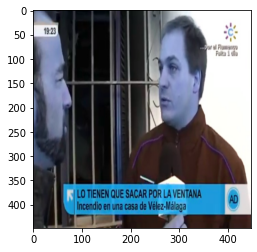

In [114]:
from torchvision.transforms import ToTensor, ToPILImage

tf_toPILImage = ToPILImage()
img_PIL= tf_toPILImage(img[0])
plt.imshow(img_PIL)

In [136]:
img1, target, semi, current_size  = train_dataset.__getitem__(1)

(0, 720) (0, 1280)
./data/fire/imgs/Austin Fire Department - 911 Memorials.mp4_120.jpg


In [137]:
type(target)

list

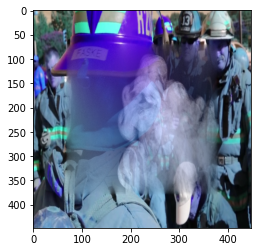

In [138]:
tf_toPILImage = ToPILImage()
img_PIL= tf_toPILImage(img1)
plt.imshow(img_PIL)